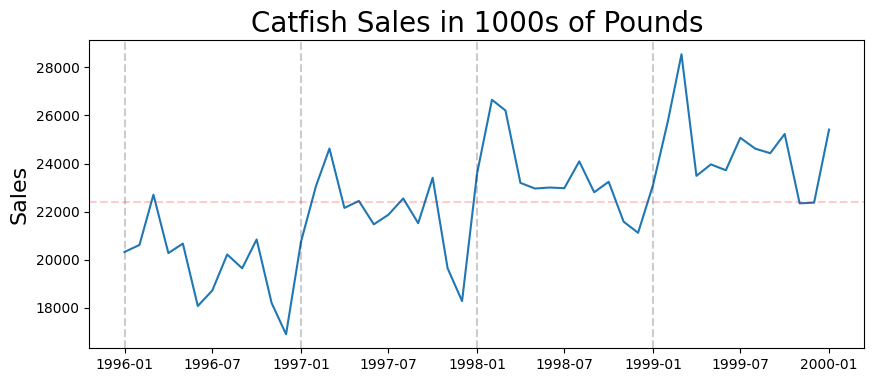

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import SARIMA
register_matplotlib_converters()
from time import time


catfish_sales = pd.read_csv(os.path.join(os.getcwd(), 'data/catfish.csv'), 
                             parse_dates=[0], index_col=0) # parse_dates = [0] indicates that we are treating the first column of our data as date. index_col = 0 means we are indexing our data using the first col

# Convert the index to datetime format if needed
catfish_sales.index = pd.to_datetime(catfish_sales.index)
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

# Take subset of data
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1) #yyyy-dd-mm
lim_catfish_sales = catfish_sales[start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.astype(float).mean().item(), color='r', alpha=0.2, linestyle='--') # converts lim_catfish_sales from object to float, convert calculated mean series to scalar using .item()

### Remove the trend

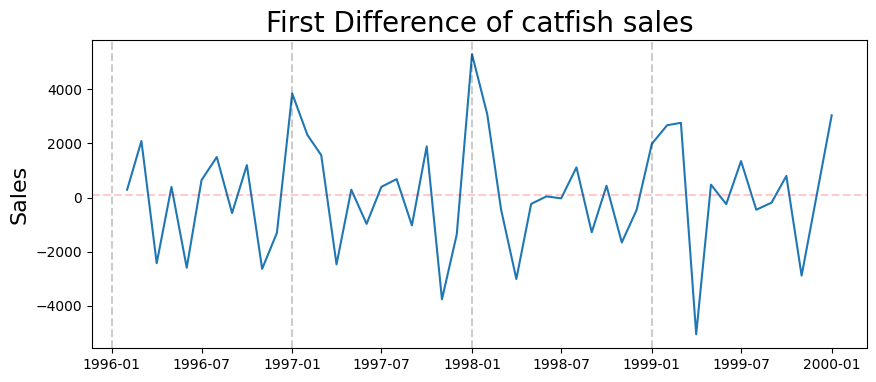

In [3]:
first_diff = lim_catfish_sales.diff()[1:]
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of catfish sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.astype(float).mean().item(), color='r', alpha=0.2, linestyle='--') # converts lim_catfish_sales from object to float, convert calculated mean series to scalar using .item()


### ACF

<BarContainer object of 15 artists>

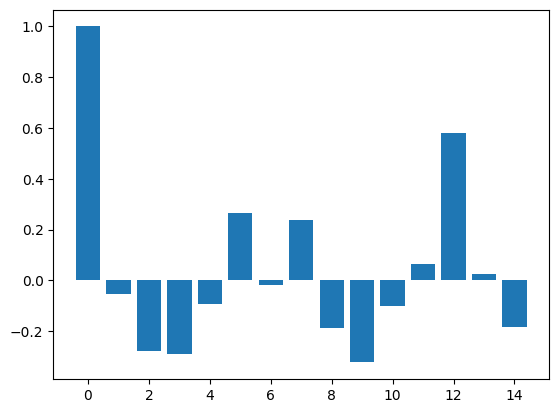

In [4]:
acf_vals = acf(first_diff)
num_lags = 15
plt.bar(range(num_lags), acf_vals[:num_lags])

##### Based on the ACF, spike at lag 12 indicates seasonal behaviour at the 12 months mark. Hence we should start with a seasonal MA process

### PACF

<BarContainer object of 15 artists>

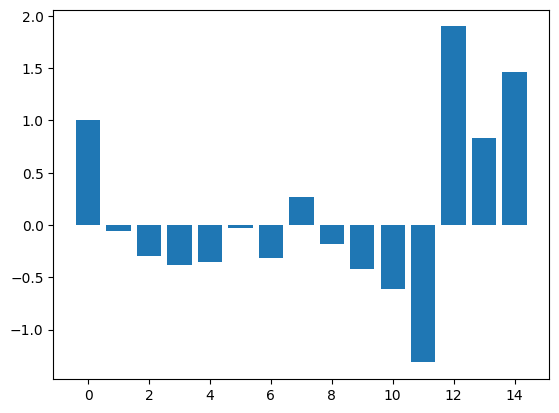

In [5]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

##### Based on spike at lag 12 on PACF, we should go with a seasonal AR process

### Get training and testing set

In [6]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

### Fit SARIMA Model

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
my_order = (0, 1, 0) # We took first difference to achieve stationality
my_seasonal_order = (1, 0, 1, 12) # ACF and PACF plot shows AR(1) and MA(1) with m=12 seasonal period
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [12]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.128997802734375


c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [14]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Fri, 01 Nov 2024   AIC                            737.269
Time:                                      16:34:16   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8251      0.120      6.850      0.000       0.589       1.061
ma.S.L12      -0.51

Root Mean Squared Error: 1122.3420851962803


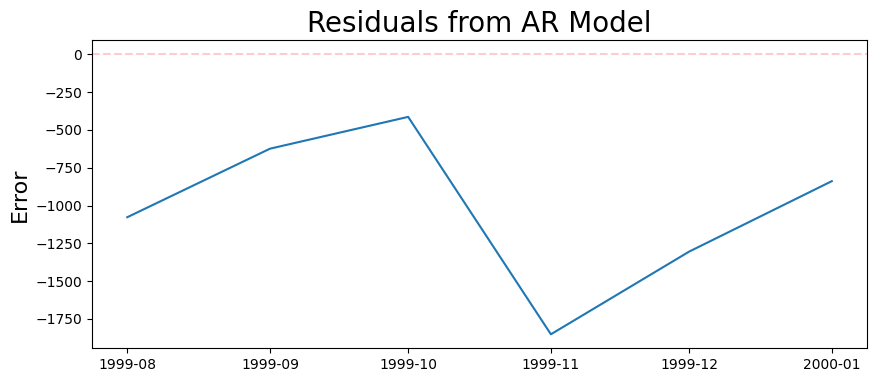

In [15]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data.Total - predictions

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Residuals plot indicate systematic bias in our prediction as all errors are < 0

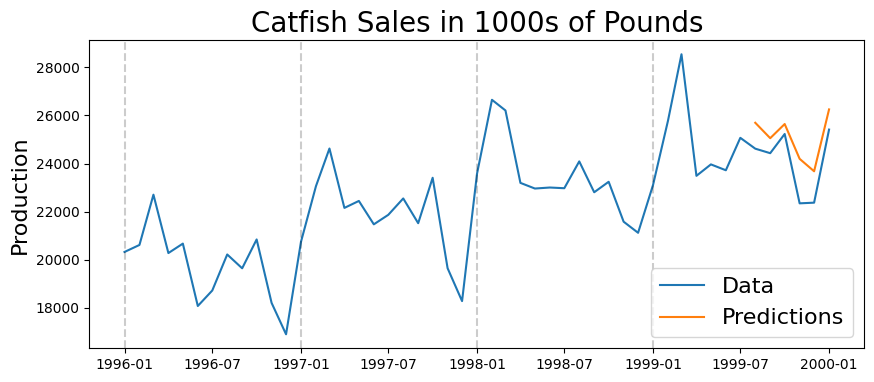

In [16]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [17]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))


Mean Absolute Percent Error: nan
Root Mean Squared Error: 1122.3420851962803


### Using the Rolling Forecast Origin

### Idea: Predict one month in advance each time
#### Train on months 1,2 ... , k-3 -> predict month k-2
#### Train on months 1,2 ... , k-3, k-2 -> predict month k-1
#### Train on months 1,2 ... , k-3, k-2, k-1 -> predict month k

In [66]:
rolling_predictions = test_data.copy()
for train_end in test_data.index: # for each month in test_data
    
    # Get data all the way uptil 1 day before train_end, train model and predict train_end
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)] 
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast() # default steps=1, meaning predict the next immediate date i.e train_end
    rolling_predictions[train_end] = pred # append onto rolling predictions

c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\code\time_series\venv\lib\site-pack

In [67]:
rolling_residuals = test_data.Total - rolling_predictions


In [69]:
# Convert multi-index df to a series, dropping level=1 (column index)
rolling_residuals = rolling_residuals.stack().reset_index(level=1, drop=True)

Text(0, 0.5, 'Error')

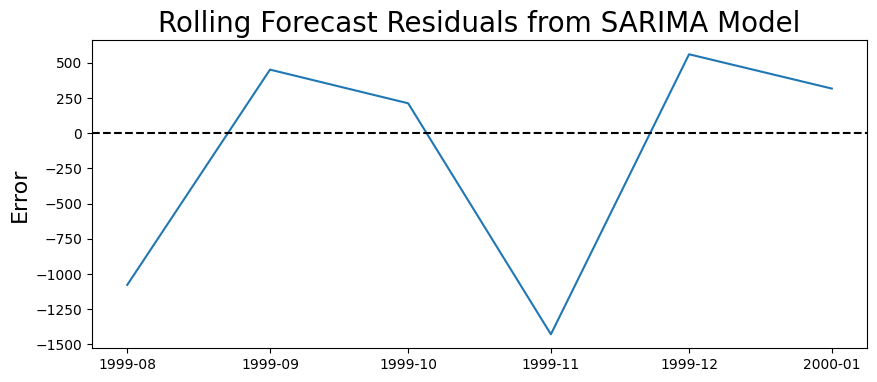

In [70]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals.fillna(0))
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

#### Plot prediction of rolling forecast

In [72]:
rolling_predictions = rolling_predictions.stack().reset_index(level=1, drop=True)

In [73]:
rolling_predictions

Date
1999-08-01    24618.000000
1999-08-01    25695.523112
1999-09-01    24430.000000
1999-09-01    23978.176793
1999-10-01    25229.000000
1999-10-01    25016.448994
1999-11-01    22344.000000
1999-11-01    23772.564130
1999-12-01    22372.000000
1999-12-01    21811.161004
2000-01-01    25412.000000
2000-01-01    25094.783964
dtype: float64

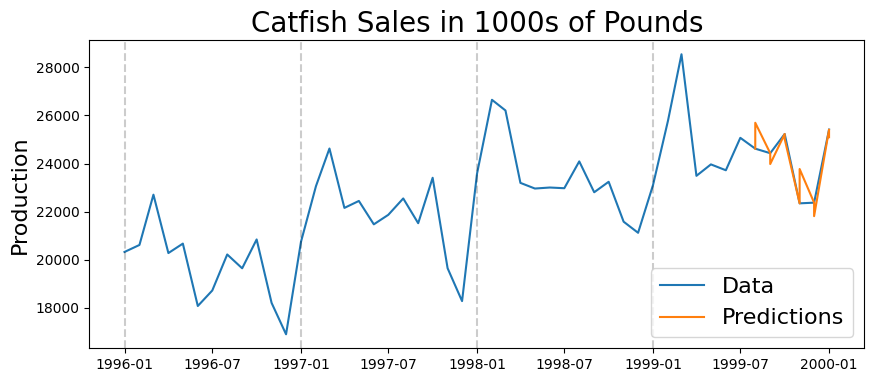

In [74]:

plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [76]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data.Total)),4))


Mean Absolute Percent Error: 0.0287


In [77]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))


Root Mean Squared Error: 802.7390677186904
